In [1]:
import numpy as np
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_breusch_godfrey
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
from math import sqrt
from sklearn.metrics import mean_squared_error
import json

In [2]:
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

In [3]:
with open('config.json') as f:
    config = json.load(f)

data_path = config["data_path"]

ts = pd.read_csv(data_path)

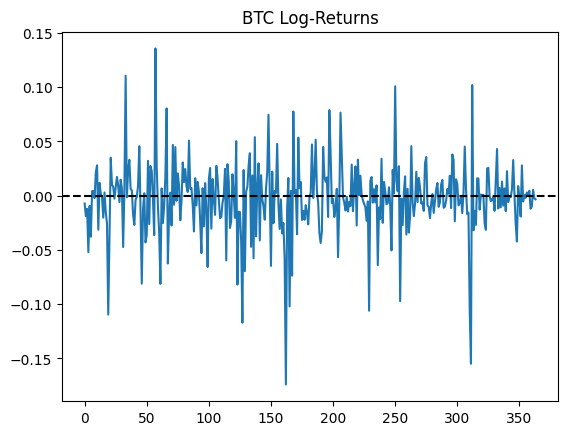

In [4]:
ts = ts["Close"].values
ts_log = np.log(ts)
returns = np.diff(ts_log)

plt.plot(returns)
plt.axhline(y=0, c="black", linestyle="--")
plt.title("BTC Log-Returns")
plt.show()

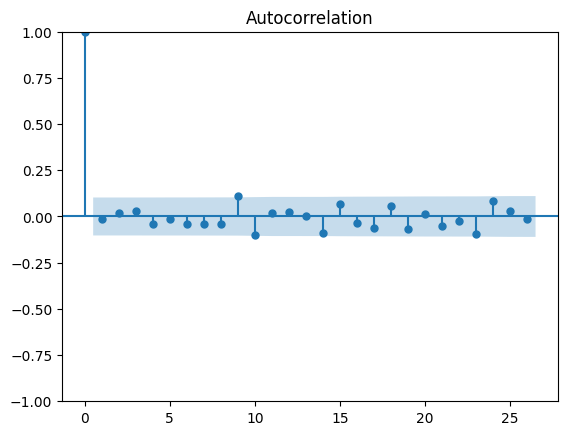

In [5]:
plot_acf(returns)
plt.show()

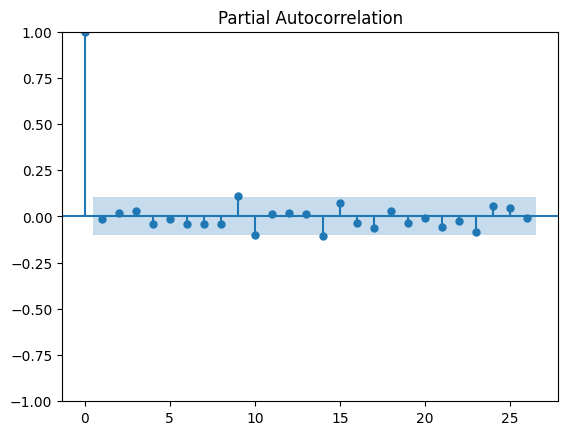

In [6]:
plot_pacf(returns)
plt.show()

In [7]:
unit_test = adfuller(returns)

#Print results
print('ADF Statistic: %f' % unit_test[0])
print('p-value: %f' % unit_test[1])
print('Critical Values:', unit_test[4])

if unit_test[1] <= 0.05:
    print(f'Reject the null hypothesis. The time-series is stationary.')
else: 
    print(f"Fail to reject the null hypothesis. The time-series is non-stationary")

ADF Statistic: -19.230854
p-value: 0.000000
Critical Values: {'1%': np.float64(-3.448493650810824), '5%': np.float64(-2.8695352280356556), '10%': np.float64(-2.5710293341377715)}
Reject the null hypothesis. The time-series is stationary.


In [8]:
train_size = int(len(ts)*0.70)
train, test = returns[:train_size], returns[train_size:]

In [20]:
lowest_bic = None
best_p = None
best_q = None

for p in range(1,6):
    for q in range(1,6):
        #create model
        model=ARIMA(train, order=(p,0,q))
        results = model.fit()

        #select model based on BIC
        aic = results.aic
        bic = results.bic
        print(f"AR({p}), MA({q}), AIC: {aic}, BIC: {bic}")
        if lowest_bic == None:
            lowest_bic = bic
            best_p = p
            best_q = q
        elif bic < lowest_bic:
            lowest_bic = bic
            best_p = p
            best_q = q

print(f"Best ARMA order: ({best_p},0,{best_q})")

AR(1), MA(1), AIC: -962.4823121343659, BIC: -948.3172579537322
AR(1), MA(2), AIC: -961.3256586502762, BIC: -943.619340924484
AR(1), MA(3), AIC: -961.7777272944978, BIC: -940.5301460235472
AR(1), MA(4), AIC: -957.7617444223911, BIC: -932.9728996062821
AR(1), MA(5), AIC: -956.2520882327432, BIC: -927.9219798714757
AR(2), MA(1), AIC: -961.2311139925937, BIC: -943.5247962668016
AR(2), MA(2), AIC: -959.4365649179625, BIC: -938.1889836470119
AR(2), MA(3), AIC: -956.9163657536477, BIC: -932.1275209375387
AR(2), MA(4), AIC: -959.4586240112912, BIC: -931.1285156500238
AR(2), MA(5), AIC: -955.6247295758974, BIC: -923.7533576694716
AR(3), MA(1), AIC: -963.0271833158822, BIC: -941.7796020449316
AR(3), MA(2), AIC: -957.8956796080918, BIC: -933.1068347919828
AR(3), MA(3), AIC: -959.9791721366792, BIC: -931.6490637754117
AR(3), MA(4), AIC: -953.844654072116, BIC: -921.9732821656902
AR(3), MA(5), AIC: -956.4537982286793, BIC: -921.041162777095
AR(4), MA(1), AIC: -957.8684024718914, BIC: -933.079557655

e:\Projects\Github\Predicting-Bitcoin-Returns-with-Long-Short-Term-Memory-LSTM-Neural-Networks\lstm-senior-project\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
e:\Projects\Github\Predicting-Bitcoin-Returns-with-Long-Short-Term-Memory-LSTM-Neural-Networks\lstm-senior-project\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


AR(4), MA(3), AIC: -954.1174551225618, BIC: -922.246083216136
AR(4), MA(4), AIC: -953.2281084055896, BIC: -917.8154729540054
AR(4), MA(5), AIC: -952.9184486031368, BIC: -913.964549606394
AR(5), MA(1), AIC: -955.993031026547, BIC: -927.6629226652796
AR(5), MA(2), AIC: -953.9513108412772, BIC: -922.0799389348514
AR(5), MA(3), AIC: -952.7871833584804, BIC: -917.3745479068962
AR(5), MA(4), AIC: -951.3363194015697, BIC: -912.3824204048269
AR(5), MA(5), AIC: -951.2611602776365, BIC: -908.7659977357354
Best ARMA order: (1,0,1)


In [22]:
model = ARIMA(train, order=(3,0,1))
results = model.fit()
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  255
Model:                 ARIMA(3, 0, 1)   Log Likelihood                 487.514
Date:                Wed, 04 Dec 2024   AIC                           -963.027
Time:                        20:23:46   BIC                           -941.780
Sample:                             0   HQIC                          -954.481
                                - 255                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0039      0.002     -1.575      0.115      -0.009       0.001
ar.L1         -0.9433      0.096     -9.851      0.000      -1.131      -0.756
ar.L2          0.0367      0.094      0.388      0.6

In [23]:
fitted = results.fittedvalues

In [24]:
mse = mean_squared_error(train, fitted)
rmse = sqrt(mse)
print(f"Train RMSE: {rmse}")

Train RMSE: 0.035758661799796546


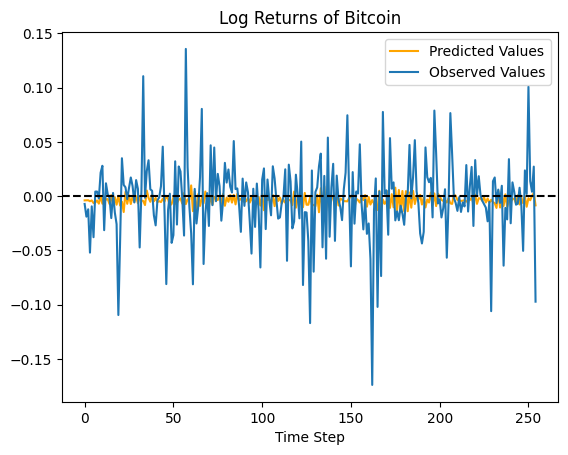

In [25]:
plt.plot(fitted, c='orange', label="Predicted Values")
plt.plot(train, label='Observed Values')
plt.axhline(y=0, c="black", linestyle="--")
plt.xlabel('Time Step')
plt.title('Log Returns of Bitcoin')
plt.legend()
plt.show()

### Residual Diagnostics

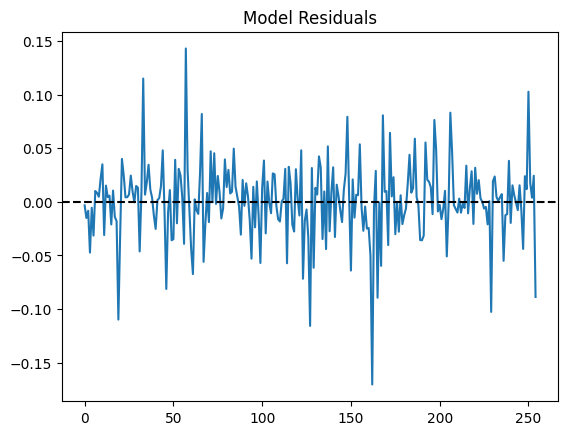

In [26]:
residuals = results.resid
plt.plot(residuals)
plt.axhline(y=0, c="black", linestyle="--")
plt.title("Model Residuals")
plt.show()

In [27]:
lagrange_t_stat, p_value, _, _ = acorr_breusch_godfrey(results, nlags=12)
print(f"Results from Breusch-Godfrey Test\nTest-Statistic: {lagrange_t_stat}\nP-Value: {p_value}")

if p_value <= 0.05:
    print(f"Reject the null hypothesis. Presence of serial correlation in the residuals is likely.")
else: 
    print(f"Fail to reject the null hypothesis. Evidence does not suggest serial correlation.")


Results from Breusch-Godfrey Test
Test-Statistic: 10.151472747755134
P-Value: 0.6026739139185489
Fail to reject the null hypothesis. Evidence does not suggest serial correlation.


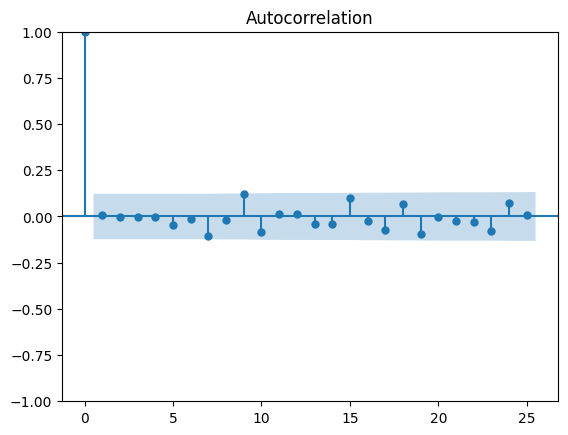

In [28]:
plot_acf(residuals)
plt.show()

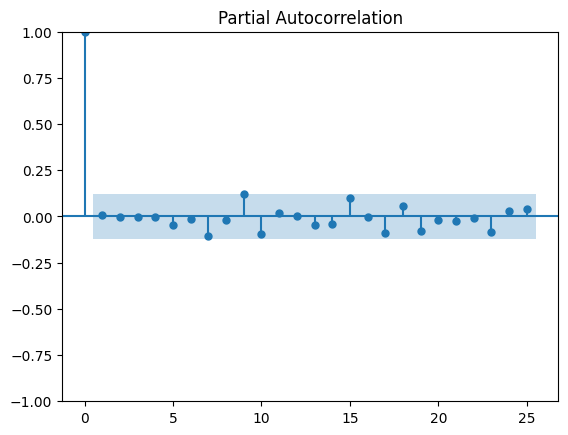

In [29]:
plot_pacf(residuals)
plt.show()

## Model Testing


In [44]:
def rolling_forecast():

    history = list(train)
    predictions = []

    for i in range(len(test+1)):
        model = ARIMA(history, order=(3,0,1))
        results = model.fit()
        
        #One-step-ahead forecast
        yhat = results.forecast()
        yhat = yhat[0]

        #Append history and predictions
        obs = test[i] #most recent observation
        history.append(obs)
        predictions.append(yhat)
        
        #Print predictions and observations at each step
        print(f'Step {i+1}: Observed: {obs}, Predicted: {yhat}')

    return predictions
            
yhat_test = rolling_forecast()

Step 1: Observed: -0.0027439687990540307, Predicted: 0.0030682377486740443
Step 2: Observed: -0.027034585929099464, Predicted: -0.010624103721913414
Step 3: Observed: 0.0036162278252707125, Predicted: -0.006264594221059169
Step 4: Observed: 0.01779449284384782, Predicted: -0.004852945177730453
Step 5: Observed: -0.03581280592216096, Predicted: -0.003929139827767367
Step 6: Observed: 0.006396912182601966, Predicted: -0.0016121793803511582
Step 7: Observed: -0.03400047787130056, Predicted: -0.004654717681553337
Step 8: Observed: -0.01834481341658112, Predicted: -0.003501088761113604
Step 9: Observed: 0.045641677518439394, Predicted: -0.004834114096323402
Step 10: Observed: -0.005988576329485795, Predicted: -0.006072315283024392
Step 11: Observed: -0.018864440546158434, Predicted: -0.0012931023431560092
Step 12: Observed: -0.007149857903650414, Predicted: -0.0016297955579808309
Step 13: Observed: 0.022121968217957644, Predicted: -0.004284754182923629
Step 14: Observed: -0.0058500341686418

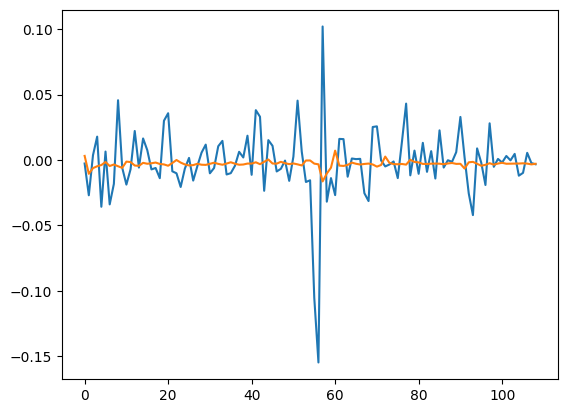

In [45]:
plt.plot(test)
plt.plot(yhat_test)
plt.show()